# Zipf's Law

```yaml
course:   DS 5001 
module:   05 5 Lab
topic:    Zipf's Law and Open/Closed Terms
author:   R.C. Alvarado
date:     13 February 2024
```

# Set Up

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt

In [2]:
sns.set()

## Config

Change this to match the location of your data files.

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [4]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [5]:
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [6]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index(BOOKS)
TOKEN = pd.read_csv(f'{output_dir}/{data_prefix}-TOKEN.csv').set_index(OHCO).dropna()
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB.csv').set_index('term_str').dropna()
POS_GROUP = pd.read_csv(f'{output_dir}/{data_prefix}-POS_GROUP.csv').set_index('pos_group')

# Zipf's Law

Recall the formula Zipf's law $f \propto \frac{1}{r} $, and $k =  fr$. 

We explore our data to see if it matches the formula.

## Add Term Rank to VOCAB

First, we compute the rank of each word, which is just its numeric index when inversely sorted by frequency.

In [7]:
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank' 
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_str')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

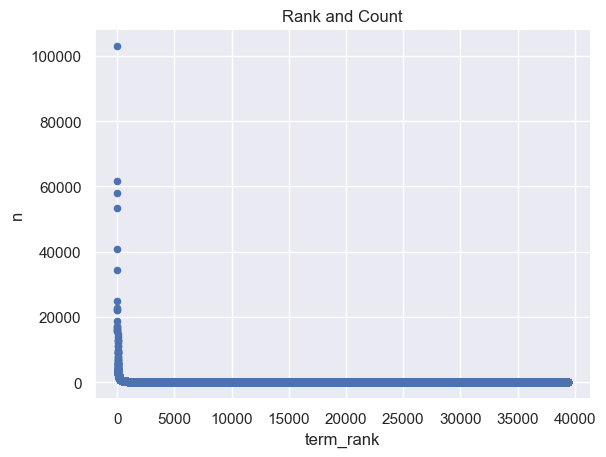

In [8]:
VOCAB.plot.scatter('term_rank', 'n', title="Rank and Count");

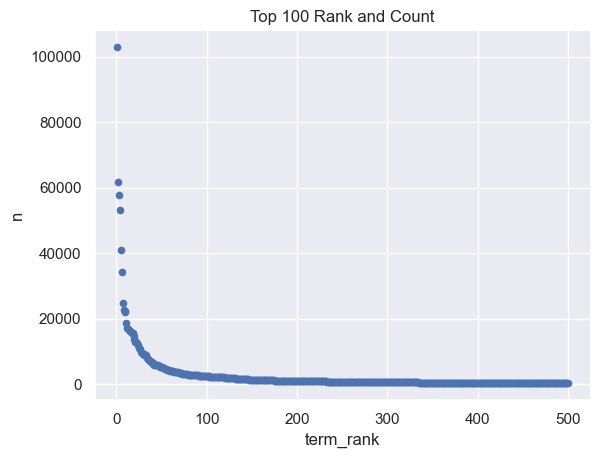

In [9]:
VOCAB.head(500).plot.scatter('term_rank', 'n', title="Top 100 Rank and Count");

## Guess Minimum Rank for Stop Words

In [10]:
min_rank = 200
SW = VOCAB[VOCAB.term_rank <= min_rank].index.tolist()

In [11]:
for i, sw in enumerate(SW):
    print(sw, end='')
    print() if (i+1) % 15 == 0 else print(' ', end='')

the of and to a in i was that it his he as her with
not for but be you is had at she all by have on my so
from this him which were they no me one their would very an or we
been there now what are could them more when some if said will upon who
your do such any than like must man then into out mr much time up
only our other little being its though did well how good before should own every
after never most old mrs about over might these long am may us two has
first can again here know yet great say down see think himself without too nothing
still last miss made day many ever way while those soon sir seemed thought where
men come away shall thing go captain herself pierre even off through came sea make
same young three however just house always indeed hand having oh round once almost something
room quite look among place world far dear another nor cried life lady under whale
heart side ship part give let take mind head better few half myself things found
till present back poor moment 

## Log View

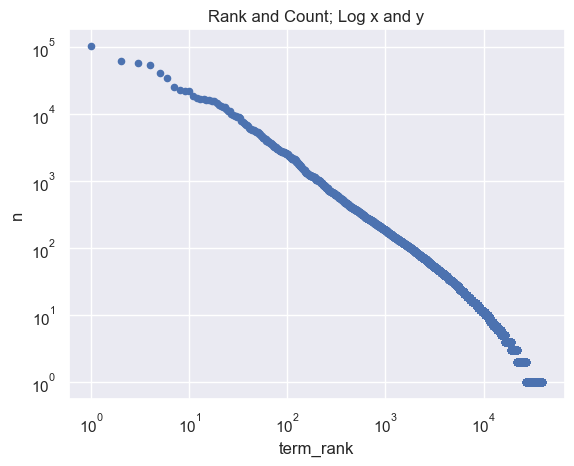

In [12]:
VOCAB.plot.scatter('term_rank', 'n', logx=True, logy=True, title="Rank and Count; Log x and y");

## Create Alternate Rank

Raw term rank has the problem of arbitrarily assigning rank numbers to terms that have the same count -- essentially terms with the same count are assigned a value based on their alphanumeric sort order. So we come up with a different rank that is a function of term count only.

In [13]:
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'index':'term_rank2', 'count':'nn'})\
    .set_index('n')

In [14]:
VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1

# Compare Ranks

Note how the two ranks are related: the alternate rank groups more terms as frequency gets smaller.

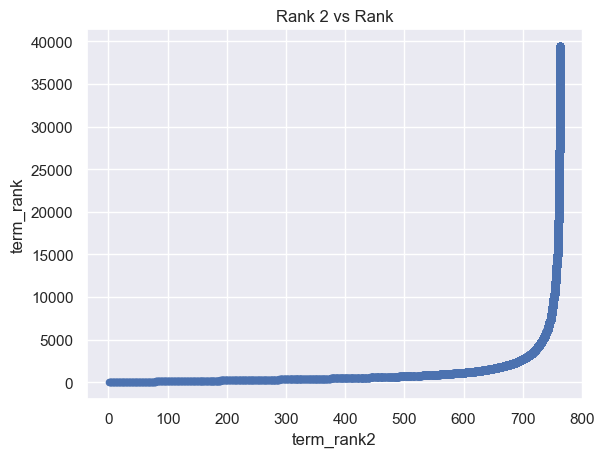

In [15]:
VOCAB.plot.scatter('term_rank2', 'term_rank', title="Rank 2 vs Rank");

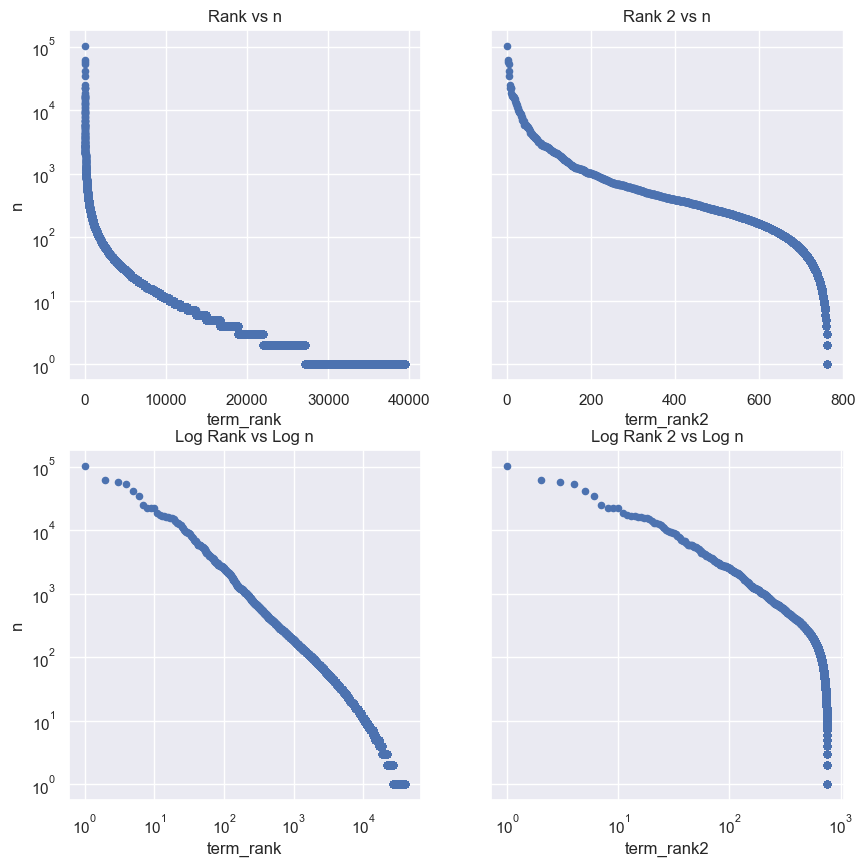

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharey=True)
VOCAB.plot.scatter('term_rank', 'n', title="Rank vs n", ax=axes[0,0])
VOCAB.plot.scatter('term_rank2', 'n', title="Rank 2 vs n", ax=axes[0,1]);
VOCAB.plot.scatter('term_rank', 'n', logx=True, logy=True, title="Log Rank vs Log n", ax=axes[1,0])
VOCAB.plot.scatter('term_rank2', 'n', logx=True, logy=True, title="Log Rank 2 vs Log n", ax=axes[1,1]);

## Compute Zipf's K

Now we see if K is linear as it's supposed to be.

In [17]:
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2

## Rank and Zipf $k$

$k$ is supposed to be constant.

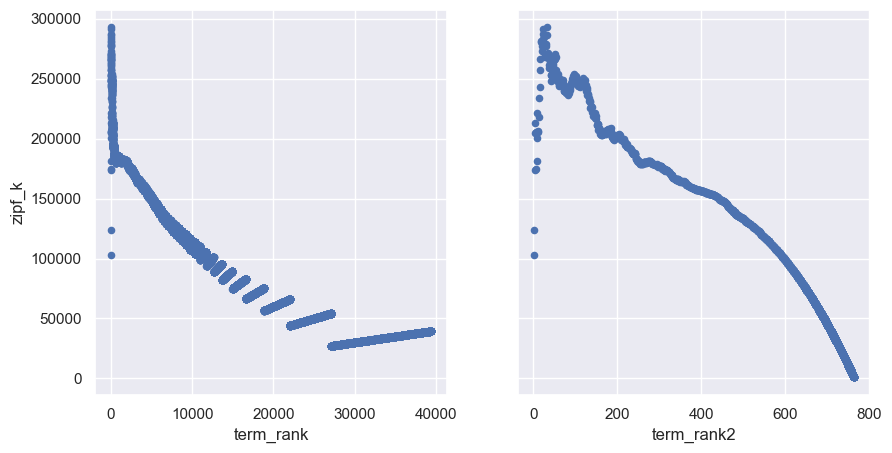

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
VOCAB.plot.scatter('term_rank', 'zipf_k', ax=axes[0])
VOCAB.plot.scatter('term_rank2', 'zipf_k2', ax=axes[1]);

## Demo Rank Index

We look at a sample drawn from rank increments to see global patterns in the corpus.

In [19]:
rank_index = [1, 2, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

In [20]:
DEMO = VOCAB.loc[VOCAB.term_rank.isin(rank_index)][['max_pos', 'p', 'term_rank', 'term_rank2', 'i', 'zipf_k', 'zipf_k2']]

In [21]:
DEMO.style.background_gradient(cmap='YlGnBu', high=.5)

,max_pos,p,term_rank,term_rank2,i,zipf_k,zipf_k2
term_str,,,,,,,
the,DT,0.053081,1,1,4.235670,102962,102962
of,IN,0.031850,2,2,4.972570,123560,123560
and,CC,0.029874,3,3,5.064951,173844,173844
it,PRP,0.011400,10,10,6.454815,221130,221130
you,PRP,0.007142,20,20,7.129407,277080,277080
so,RB,0.004766,30,30,7.713121,277320,277320
their,PRP$,0.003427,40,40,8.188935,265880,265880
are,VBP,0.002773,50,50,8.494300,268950,268950
who,WP,0.002167,60,60,8.850218,252180,252180


## Rank and Information

Rank and information appear to be closely related.

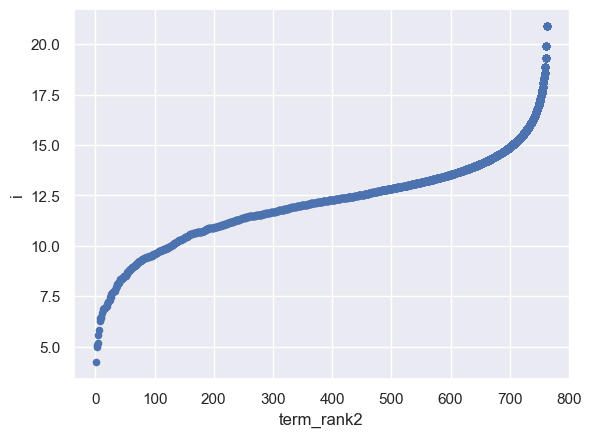

In [22]:
VOCAB.plot.scatter('term_rank2', 'i', logx=False, logy=False);

And, log $r$ tracks with $i$.

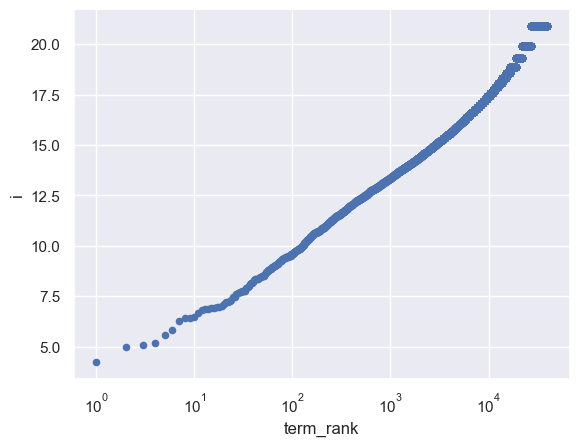

In [23]:
VOCAB.plot.scatter('term_rank', 'i', logx=True, logy=False);

In [24]:
VOCAB['log_r'] = np.log2(VOCAB.term_rank)

In [25]:
VOCAB[['log_r','i']].corr()

,log_r,i
log_r,1.000000,0.982275
i,0.982275,1.000000


Also, $i$ vs $r$ provides an example of logistic growth. 

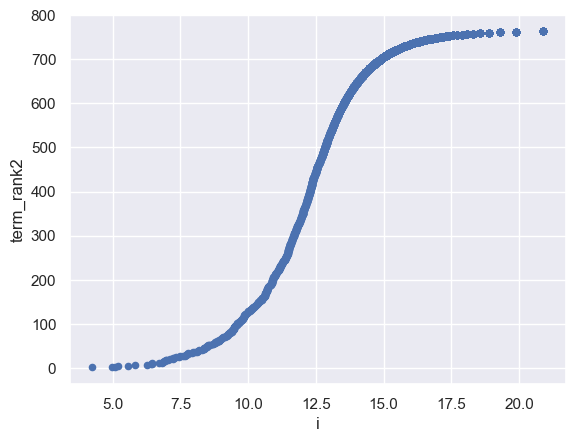

In [26]:
VOCAB.plot.scatter('i', 'term_rank2', logx=False, logy=False);

## Observations

* Zipf's law sheds light on a basic structure of language -- the division between words that do **grammatical work** and those that do **semantic work**.
* Zipf's constant is not borne out by the data. 
* Zipf's rank order does not group words with the same count; so, we've created an alternate rank based on word count groupings.
* Information $i$ may be used as a replacement for rank when exploring corpus level significance trends.

# Extra: Open vs Closed Words

Let's look at the concept of open and closed words.

We can do this by compare the number of types (terms) and tokens for each POS.

In [27]:
POS_GROUP['n_terms'] = VOCAB.max_pos.value_counts() 
POS_GROUP['n_tokens'] = VOCAB.groupby('max_pos').n.sum()

In [28]:
POS_GROUP['type_token_ratio'] = POS_GROUP.n_terms / POS_GROUP.n_tokens

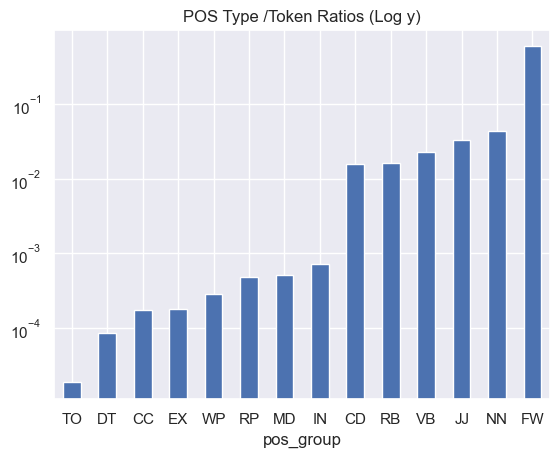

In [29]:
POS_GROUP.type_token_ratio.dropna().sort_values()\
    .plot.bar(logy=True, rot=0, title="POS Type /Token Ratios (Log y)");

We can see in both charts that two groups of words form.

| CLASS | TYPE/TOKEN | POS | THRESH |
|--|--|--|--|
| Open | High | Nouns, Adjectives, Verbs, Adverbs, Foreign Words* | $> 10^{-2}$ |
| Closed | Low | Function words | $< 10^{-3}$|

\*Foreigns words are typically nouns.

# Save

In [30]:
DEMO.to_csv(f"{output_dir}/{data_prefix}-DEMO.csv")
VOCAB.to_csv(f"{output_dir}/{data_prefix}-VOCAB_RANKED.csv")